# Introduction to Regression



## Setup

Please run each block of code in sequence.

In [3]:
%matplotlib inline

This function renders matplotlip figures in your notebook. 

In [4]:
%run setup.py

This module defines two functions and imports the different Python packages we will use to implement and experiment with our Regression models in this part of the course.

It is also a python script rather than a notebook so if you open it to have a look you will see only code. The entire script will be run except for any text following a # symbol. These texts are called comments and are useful for explaining what each section of code does or temporarily muting a piece of code.

## Example 1 - Simple Linear Regression

To begin, we will examine a simple linear function where we know the true underlying relationship between the dependent (`y`) and independent (`x`) variable. We define this relationship by creating the Python function called `true_func`,

In [5]:
def true_func(x):
    return 4 + 3 * x

Our goal is to recover the slope and intercept of this linear model from observing pairs of `y` and `x` values. To make this problem non-trivial, and realistic, all of our observations of `y` will be made with uncertainty (noise).

We generate 50 random `x` values drawn uniformly from the $[0,1]$ interval and then "observe" 50 corresponding `y` values which are the result of calculating the true function for the given value of `x` and then adding random noise, which is drawn from a normal distribution with mean 0 and standard deviation 0.5. Note - we use `np.random.seed(1234)` to set a random seed for NumPy's pseudo-random number generator so that each time this cell is (re)run we will obtain the same values of `x` and `y`.

In [6]:
np.random.seed(1234)

n = 50
x = np.random.rand(n, 1)
y = true_func(x) + 0.5 * np.random.randn(n, 1)

We can then plot these data use `pyplot`'s `plot` function to generate a scatter plot.

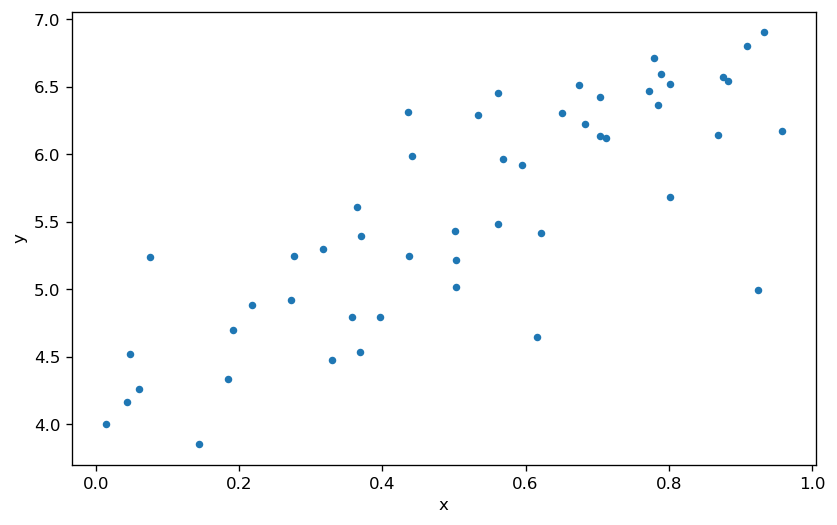

In [7]:
plt.plot(x, y, ".")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

For these data it is also useful to illustrate the underlying true function that we are trying to estimate. Here we create a new variable `x_pred` which is a vector of 100 equally spaced values between 0 and 1 using `np.linspace`. The `pred` suffix is something we will use regularly and is used to indicate that a variable is a collection of values that will be used for prediction. Usually, these prediction vectors or matrices will have a higher resolution than the original data, this is done so that our regression lines with similarly have higher resolution. Clearly when drawing a simple line this is not necessary, but will be when we explore more complex relationships down the road.

Finally, we use `x_pred` to calculate `y_truth` using the `true_func` function.

In [8]:
x_pred = np.linspace(0, 1, num=100)
y_truth = true_func(x_pred)

We can now create a new plot that includes both the observed data along with a line showing the true function.

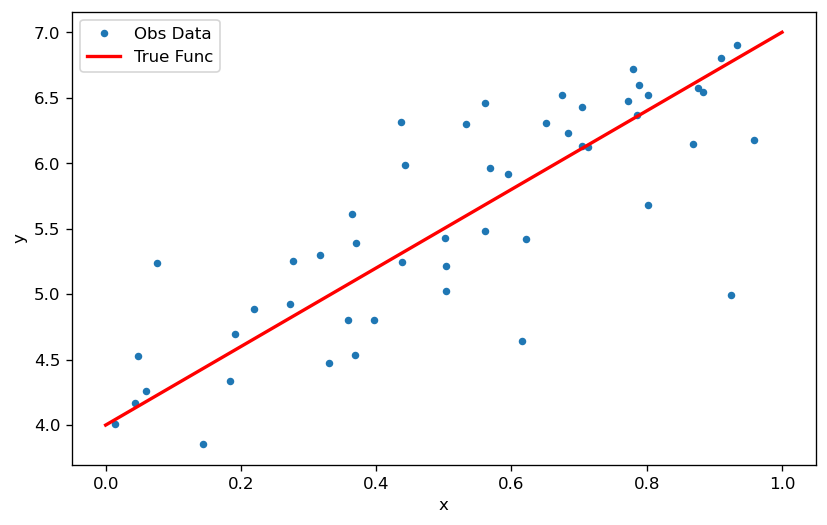

In [9]:
plt.plot(x, y, ".", label="Obs Data")
plt.plot(x_pred, y_truth, "r-", label="True Func")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Note that we have included the `label` argument with both plot calls so that we can automatically construct a legend for our plot.

In order to estimate the true relationship we will be using the method of least squares,

$$ \underset{f(x_i)}{\text{argmin}} \;\; \sum_{i=1}^n(y_i - f(x_i))^2. $$

In this particular instance we are attempting to fit a line so we can write this as,

$$ \underset{\beta_0, \beta_1}{\text{argmin}} \;\; \sum_{i=1}^n(y_i - \beta_0 - \beta_1 x_i)^2. $$

### Exploration

First, let's explore manually which values of $\beta_0$ and $\beta_1$ minimises the sum of squares.

The following function returns a plot with the observed data, the true function and a (purple) regression line from a given value b0 of $\beta_0$ and a given value b1 of $\beta_1$.
The plot also reports the root mean square error (RMSE - see aside below) of the regression line as well as including vertical dashed lines between the estimated data $\hat{y}_i = \beta_0 + \beta_1 x_i$ and the observed data $y_i$.



In [10]:
def reg_line(b0, b1):
    y_hat = b0 + b1 * x
    y_pred = b0 + b1 * x_pred
    
    plt.plot(x, y, ".", label = "Obs Data")
    plt.plot(x_pred, y_truth, "r-", label = "True Func")
    plt.plot(x_pred, y_pred, "m-", label = "Regression")
    plt.legend()
    
    plt.vlines(x, y_hat, y, linestyles="dotted", alpha=0.5, linewidth=1)
    plt.title(r"$\^y={:.2f} + {:.2f} x$   (RMSE = {:.3f})".format(b0, b1, rmse(y, y_hat))) 
    #Using r"$ $" creates a string in math text, similar to Latex, .format() passes values, in order, to the curly brackets in the string.
    plt.show()

The interact function below (imported from ipywidgets in setup.py) draws sliding bars which you can use to pass values to a function, reg_line in this instance. Based on your choice of these parameters Jupyter will redraw the plot, including the resulting regression line.

In [11]:
interact(reg_line, b0=(0,10,0.1), b1=(-10,10,0.1))

interactive(children=(FloatSlider(value=5.0, description='b0', max=10.0), FloatSlider(value=0.0, description='…

<function __main__.reg_line(b0, b1)>

---

### &diams; Exercise 1

By manipulating the sliders what values of `b0` and `b1` produces the smallest value of RMSE? Use the arrow keys for fine tuning. 

Their answer will vary depending on their starting point. The smallest RMSE is obtained by using the values of 4.3 and 2.5 which results in an RMSE of 0.493. But they might want to start with b0=4 and b1=3 which will lead them to conclude that b0=4.1 and b1=2.9 with RMSE=0.504 is minimal.

---

### &diams; Exercise 2

Does the resulting regression line match the line of true function exactly? Explain why this is expected or unexpected.

The best fit line is not far removed from the true function but does not match it exactly. This is not unexpected since we are estimating the line based on limited noisy data.

---

#### Aside - RMSE

The root mean square error (RMSE) is a related quantity to the sum of squares 
$\left(\sum_{i=1}^n (y_i - \hat{y}_i)^2\right)$
and is defined as,

$$ \text{RMSE} = \sqrt{ \frac{1}{n} \sum_{i=1}^n(y_i - \hat{y}_i)^2 }. $$

The RMSE is often prefered, for reporting purposes, to the sum of squares since it has a more natural interpretation, a smaller scale, and has the same units as the dependent variable. Since the RMSE involves a monotonic transformation of the SS, minimizing the RMSE is equivalent to minimizing the SS and vice versa.

### Coordinate Descent

We will now use the analytic approaches that were discussed in the module lecture to solve the least squares problem for these data.

Using the method of coordinate descent we will find the solution by taking the derivative of the sum of squares with regard to $\beta_0$ and $\beta_1$, setting both equations equal to 0 and solving the system of equations for $\beta_0$ and $\beta_1$ respectively.

$$
\frac{\partial}{\partial\beta_0} \sum_{i=1}^n(y_i - (\beta_0 + \beta_1 \, x_i))^2 = 0,
\qquad
\frac{\partial}{\partial\beta_1} \sum_{i=1}^n(y_i - (\beta_0 + \beta_1 \, x_i))^2 = 0.
$$

Following a bit of calculus and algebra we obtain,

$$
\beta_0 
  = \frac{1}{n}\sum_{i=1}^n y_i - \beta_1 \frac{1}{n} \sum_{i=1}^n x_i 
  = \bar{y} - \beta_1 \bar{x},
$$

$$
\beta_1 = \frac{
  \sum_{i=1}^n (x_i y_i - x_i \bar{y} )
}{
  \sum_{i=1}^n ( x_i^2 - x_i \bar{x} )
}.
$$

---

### &diams; Exercise 3

Using the provided formulas, calculate the least squares solution $(\beta_0, \beta_1)$ for these data.

*Hint* - You can use the `numpy` function `np.mean` to calculate the mean of a vector and `np.sum` to calculate the sum of a vector. 

```python
np.sum([1,2,3]) #= 6
np.mean([1,2,3]) #= 2
```

*Hint* - All basic arithmetic operations `+`, `-`, `*`, and `/` work in a elementwise / vectorized fashion.

```python
np.array([1,2,3]) + np.array([1,2,3]) #= array([2, 4, 6])
np.array([1,2,3]) * np.array([1,2,3]) #= array([1, 4, 9])
```

In [12]:
b1 = np.sum(x * y - x * np.mean(y)) / np.sum(x**2 - x * np.mean(x))
b0 = np.mean(y) - b1 * np.mean(x)

print(b0, b1)

4.252680440800351 2.5288451490607327


Based on your calculations of `b0` and `b1` above we can draw the resulting regression line using,

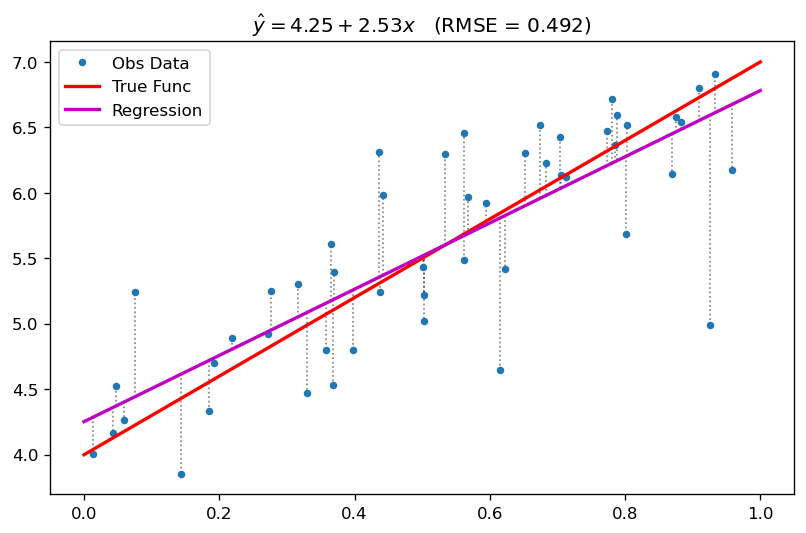

In [13]:
reg_line(b0,b1)

---

### Matrix approach

In the introductory lecture we also showed a matrix based approach for solving the least squares problem. We can rewrite the initial least squares problem as,

$$
\underset{\boldsymbol{\beta}}{\text{argmin}} \,\, \lVert \boldsymbol{y} - \boldsymbol{X} \boldsymbol{\beta} \rVert^2 
= \underset{\boldsymbol{\beta}}{\text{argmin}} \,\, (\boldsymbol{y} - \boldsymbol{X} \boldsymbol{\beta})^\top(\boldsymbol{y} - \boldsymbol{X} \boldsymbol{\beta}),
$$

where for our particular example,

$$
\underset{n \times 1}{\boldsymbol{y}} = \begin{pmatrix} y_1 \\ y_2 \\ \vdots \\ y_{n-1} \\ y_n \end{pmatrix} 
\qquad
\underset{n \times 2}{\boldsymbol{X}} = \begin{pmatrix} 1 & x_1 \\ 1 & x_2 \\ \vdots & \vdots \\ 1 & x_{n-1} \\ 1 & x_n \\ \end{pmatrix}
\qquad 
\underset{2 \times 1}{\boldsymbol{\beta}} = \begin{pmatrix} \beta_0 \\ \beta_1 \end{pmatrix}.
$$

Again with a bit of calculus and algebra we found that,

$$
\boldsymbol{\beta} = \left(\boldsymbol{X}^\top\boldsymbol{X}\right)^{-1} \boldsymbol{X}^\top\boldsymbol{y}.
$$

In Python we can construct the model matrix `X` by combining a column of ones, for the intercept, with our observed `x` values.

In [14]:
X = np.c_[np.ones(n), x]
print(X[:5])

[[1.         0.19151945]
 [1.         0.62210877]
 [1.         0.43772774]
 [1.         0.78535858]
 [1.         0.77997581]]


Given the model matrix $(\boldsymbol{X})$ and observed outcomes $(\boldsymbol{y})$ we can then calculate the vector of solutions $(\boldsymbol{\beta})$.

In [15]:
from numpy.linalg import inv

In [16]:
beta = inv(X.T @ X) @ X.T @ y
print(beta)

[[4.25268044]
 [2.52884515]]


Note that when using NumPy `*` results in an elementwise multiplication between matrices / arrays while `@` performs typical matrix multiplication. NumPy matrix multiplication can also be written as `A.dot(B)` or `np.matmul(A,B)`. Additionally, the function `inv` is also part of NumPy and is imported from `numpy.linalg`.

---

### &diams; Exercise 4

Create a plot of the results of using the matrix based approach using the `reg_line` function we previously defined. Does your answer differ from what we found when using coordinate descent?

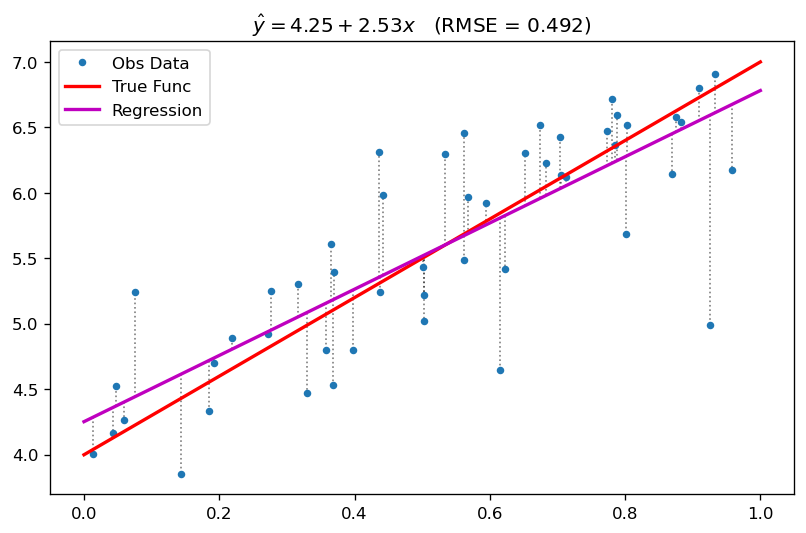

In [17]:
reg_line(float(beta[0]), float(beta[1])) 

##Note that they might get  an error with beta[i] as it returns a single value array rather than a float.

---

### scikit-Learn

Finally, we will compare our results to the results of the `LinearRegression` model provided by scikit-learn. First we will import the `LinearRegression` function from `sklearn`.

In [18]:
from sklearn.linear_model import LinearRegression

Now we will create a linear regression model object `linear_reg` and use it to fit our data. The actually fitting is handled by calling `linear_reg.fit` and passing in the vectors `x` and `y` as our independent and dependent variables. Implicitly, sklearn assumes that we would like our model to have an intercept and includes that in our results. The $\beta$ value(s) for the slope coefficients for the predictors are recovered from `reg.coef_` and the intercept is recovered from `reg.intercept_`.

In [19]:
linear_reg = LinearRegression()
reg = linear_reg.fit(x, y)
b0 = reg.intercept_[0]
b1 = reg.coef_[0,0]

print(b0, b1)

4.25268044080035 2.528845149060735


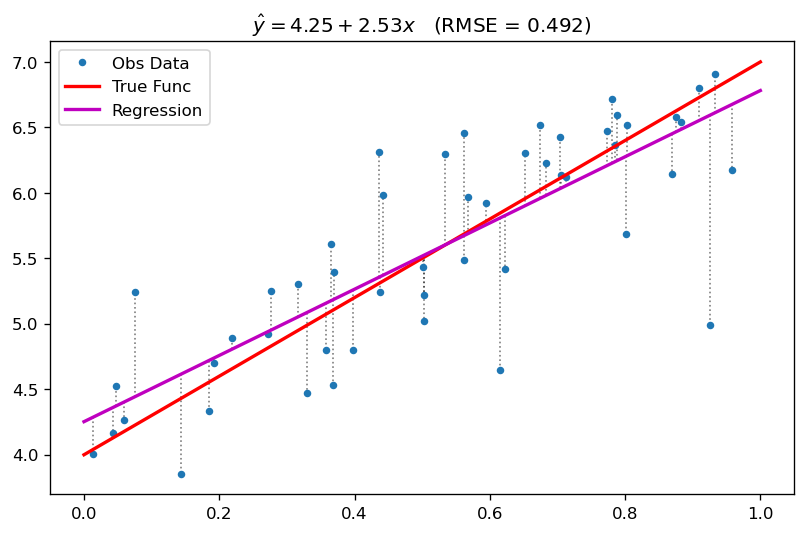

In [24]:
reg_line(b0, b1)

---

### &diams; Exercise 5

Do these results agree with the results we have previously found? 

Yes, the results are effectively identical to the two previous results.

---

### &diams; Exercise 6

Review the documentation for `sklearn.linear_model.LinearRegression`, what method does it use to find the values of $\boldsymbol \beta$? Is this method the same or different from the methods we've looked at so far in this workshop.

This model uses SciPy's ordinary least squares solver (scipy.linalg.lstsq). 


By digging a bit further, we can see that by default lstsq uses the Linear Algebra PACKage LAPACK's gelsd routine to solve the least squares problem which uses the singular value decomposition of the model matrix with an algorithm based on divide and conquer.

---

Note that if we want to construct the model matrix ourselves, including the ones column for the intercept, this is possible with `LinearRegression` we just need to pass the argument `fit_intercept = False` when creating the `linear_reg` object. Now we can pass the full model matrix to `linear_reg.fit` and additionally, all the $\beta$s are now stored in the `coef_` attribute.

In [20]:
linear_reg = LinearRegression(fit_intercept = False)
reg = linear_reg.fit(X, y)
b0, b1 = reg.coef_[0]

print(b0,b1)

4.252680440800348 2.528845149060735


## Example 2 - extending to the 3rd dimension

Everything we have seen so far generalizes beyond 2-dimensions so long as we keep things *linear* in terms of the predictors. As such we can have a regession model in $p$-dimensions by including $p$ total predictors. We can express this model as $z_i = \beta_0 + \sum_{j=1}^p \beta_j x_{ij}$ or $ \boldsymbol{z} = \boldsymbol{X}\boldsymbol{\beta}$ where $\boldsymbol{X}$ is the model matrix and is constructed as $\boldsymbol{X} = \left[ \boldsymbol{1}, \boldsymbol{x}_{\cdot 1}, \cdots,  \boldsymbol{x}_{\cdot p} \right]$

Once again we will define a true function, now in terms of $x_1$ and $x_2$, that we will observe with uncertainty.

In [21]:
def true_func(x1, x2):
    return 2 - 3 * x1 + 2 * x2

Again we define a random seed for the sake of reproducibility and then sample $x_1$ uniformly from $[0,1.5]$ and $x_2$ uniformly from $[0,3]$, our observations $y$ are then the value of the true function plus normally distributed errors, with mean 0 and standard deviation 1.

In [22]:
np.random.seed(12345)

n = 50
x1 = 1.5 * np.random.rand(n, 1)
x2 = 3 * np.random.rand(n, 1)


z = true_func(x1, x2) + np.random.randn(n, 1)

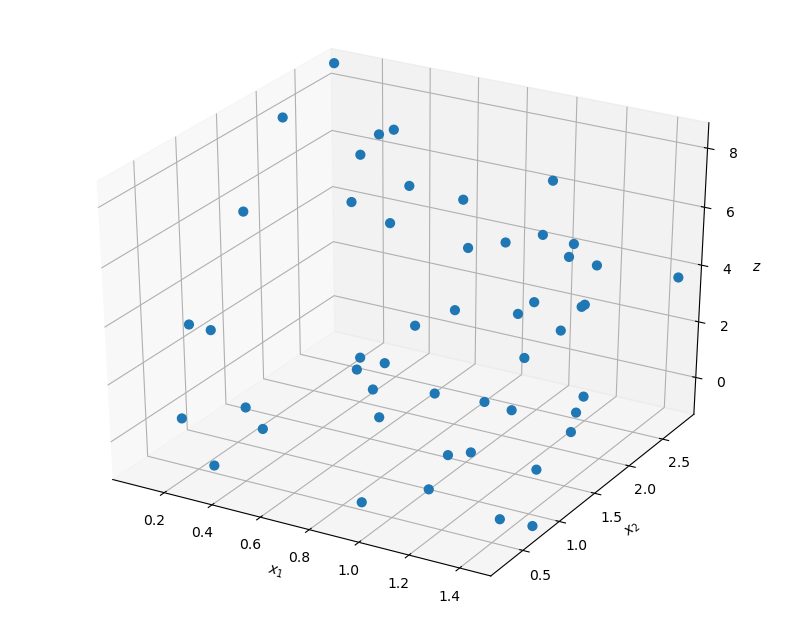

In [28]:
reg_line_3d(x1, x2, z)

As with the previous example we can setup an interactive plot where we can use sliders to guess the values of $\beta_1$, $\beta_2$, $\beta_3$.

In [23]:
def reg_line_3d_interact(b0, b1, b2):
    reg_line_3d(x1, x2, z, {"model": (b0, b1, b2)})
    
interact(reg_line_3d_interact, b0 = (-5,5,0.1), b1 = (-5,5,0.1), b2 = (-5,5,0.1))

interactive(children=(FloatSlider(value=0.0, description='b0', max=5.0, min=-5.0), FloatSlider(value=0.0, desc…

<function __main__.reg_line_3d_interact(b0, b1, b2)>

---

### &diams; Exercise 7

Starting from the values of $\beta_1$, $\beta_2$, and $\beta_3$ based on the true model, is it possible to find values of `b0`, `b1`, and `b2` that produce a lower RMSE? Explain why this is or is not possible.

Yes, as above, we are estimating the plane based on limited noisy data.

---

We can fit this model using either the linear algebra based approach or scikit-learn's `RegressionModel` function. Both of these methods depend on us correctly defining the model matrix $\boldsymbol X$. As with the 2d case this is accomplished by concatenating the $\boldsymbol{x}$ column vectors together.

In [24]:
X = np.c_[np.ones((x.shape[0],1)), x1, x2]
print(X[:5])

[[1.         1.39442414 1.59434965]
 [1.         0.47456333 0.50322669]
 [1.         0.27587822 2.30644176]
 [1.         0.30684042 2.78451165]
 [1.         0.85158754 1.82848097]]


---

### &diams; Exercise 8

Given the model matrix we have constructed above, use the linear algebra based approach to calculate $\boldsymbol\beta$.

In [25]:
beta  = inv(X.T @ X) @ X.T @ z
b0, b1, b2 = beta.flat

print(b0, b1, b2)

1.2725229160572895 -2.6216523222560744 2.2513965165416625


Once you have calculated the $\beta$s you can plot them by rerunning the following cell.

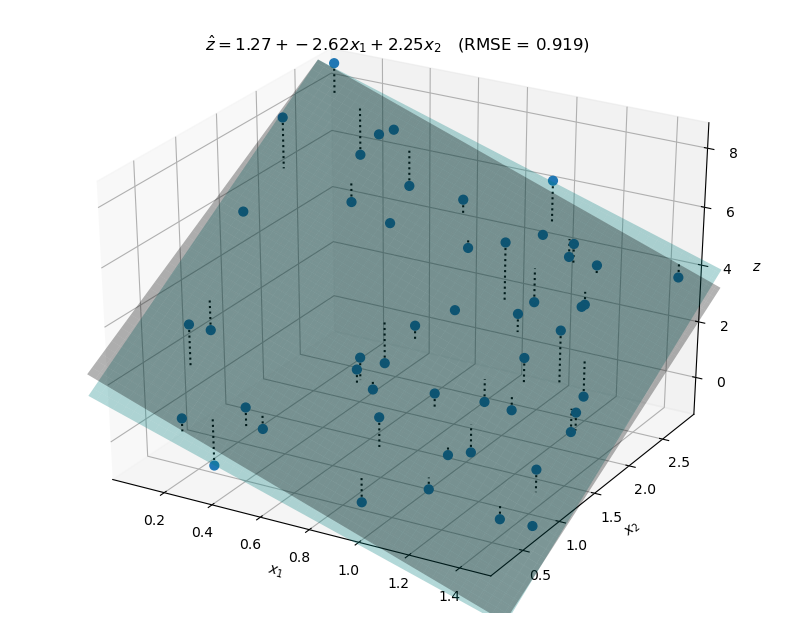

In [26]:
reg_line_3d(x1, x2, z, {"model": (b0,b1,b2), "truth": (2, -3, 2)})

---

### &diams; Exercise 9

Given the model matrix we have constructed above, use scikit learn to calculate $\boldsymbol\beta$ by adding the necessary code to the cell below.

In [28]:
linear_reg = LinearRegression(fit_intercept = False)

reg = linear_reg.fit(X,z)
b0, b1, b2 = reg.coef_.flat

print(b0, b1, b2)

1.2725229160572995 -2.6216523222560735 2.2513965165416576


Once you have calculated the $\beta$s you can plot them by rerunning the following cell.

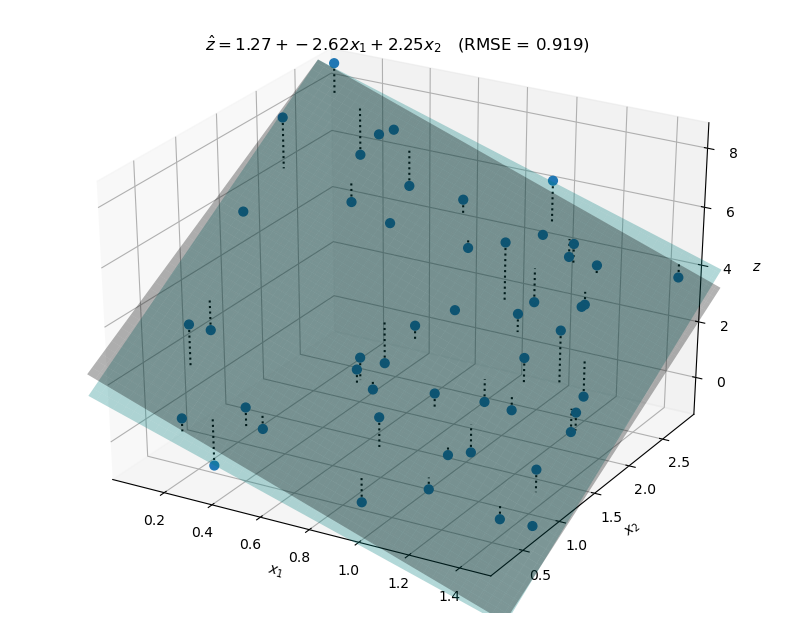

In [29]:
reg_line_3d(x1, x2, z, {"model": (b0,b1,b2), "truth": (2, -3, 2)})